# Please don't eat me - Lab

In this assignment we study exploration for targets that can move. Prey, in other words. We also add uncertainty to their capture, with a probability of escape term, _p escape_. Think of this as a successful fleeing. 

Our exploration strategies are once again random. We have no scent or memory as an aide.

The world is a grid world. 

The lab has two sections. 

- _First_ is a demo mostly. We will explore speed, scale, detection, predator number, and escape. Here we have one predator (our explorer) and one prey (our target), well mostly.
- _Second_, is where things get more interesting. We'll change the venue. Make it bigger. Add more prey, and of different species. I'll then award you with 10 "evolution points'' that you can spend by increasing the number of predators, their speed, their movement scale, or their vision.

Our metrics are metrics of death. We use two, but our focus is on their difference. 

- _Predator deaths_: Any experimental trial which does not lead to finding at least a single target (aka reward or prey) means the exploring agent (predator) dies. It's a harsh noisy world we live in, after all. 
- _Prey deaths_: The number of prey deaths is the number of targets found, which is the same as the number of rewards observed. However unlike past exploration tasks, once a prey (target) has been found it is removed from the field, and stays dead for the rest of that experiment. When the experiment resets, for each _num experiment_, all the targets spring back to life and the predator(s) get another chance.
- _Prey deaths - Predator deaths_: We'll call this last value, the difference between deaths, the _fitness score_. More positive values are better. More negative values are worse. 

## Install and import needed modules

In [ ]:
# Install explorationlib?
!pip install --upgrade git+https://github.com/parenthetical-e/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

In [77]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib
from explorationlib.agent import DiffusionGrid
from explorationlib.agent import LevyGrid
from explorationlib.agent import FreezeLevyGrid

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import CompetitiveGrid

from explorationlib.run import multi_experiment
from explorationlib.util import select_exp
from explorationlib.util import select_agent
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_positions2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import show_gif

from explorationlib import score
from explorationlib.score import num_death
from explorationlib.score import average_reward
from explorationlib.score import total_reward
from explorationlib.score import first_reward

In [2]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section 1 - a lone and hungry coyote

In this section we'll study one explorer (predator) and one target (prey) noisy, as a base case. Both will be diffusion models, to start with anyway. They will start with the same movement scale, detection radius and speed. From there we'll try some changes, to see what helps predators and _how much it helps._ We'll see what helps the prey, and _how much_.

### The base case

In [54]:
# Shared env params
num_steps = 100
num_experiments = 500
seed_value = 559

num_agents = 2
num_targets = 1
target_index = list(range(0, num_targets))

detection_radius = 1
p_target = 1
p_escape = (1 - p_target)

target_boundary = (10, 10)

step_size = 1
min_length = 1
detection_radius =  1
scale = 2

# Create env 
prng = np.random.RandomState(seed_value)
env = CompetitiveGrid(num_agents=num_agents, mode=None)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1.0)

#### Question 1.1

We start with an equal match, scale, speed, number, on a small domain, with a detection radius that's about 10 percent of the domain. Make a guess. Will the fitness score be a positive number on average, or a negative one? Explain yourself.

That is, does it even make sense to hunt alone when you don't have any advantage?

In [55]:
# Write your answer here as comment. 

Let's see if you were right

In [56]:
model_codes = [0]
results = []

# Intial targets
env.add_targets(
    target_index, 
    targets, 
    values, 
    detection_radius=detection_radius, 
    p_target=p_target
)

# Preds
pred = [
    DiffusionGrid(
        scale=scale, 
        min_length=min_length, 
        step_size=step_size
    )
]

# Preys
prey = [
    DiffusionGrid(
        scale=scale, 
        min_length=min_length, 
        step_size=step_size,
    )
] 

# All agents
agents = prey + pred

# !
comp_exp = multi_experiment(
    f"base",
    agents, 
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    seed=seed_value,
    split_state=False,
    dump=False
)

# -
results.append(comp_exp)

base: 100%|██████████| 500/500 [00:11<00:00, 43.25it/s]


In [57]:
print(f"Prey index : {target_index}")

Prey index : [0]


### Examples
Plot 5 example experiments of a predator search, prey evasion. Both are random walks.

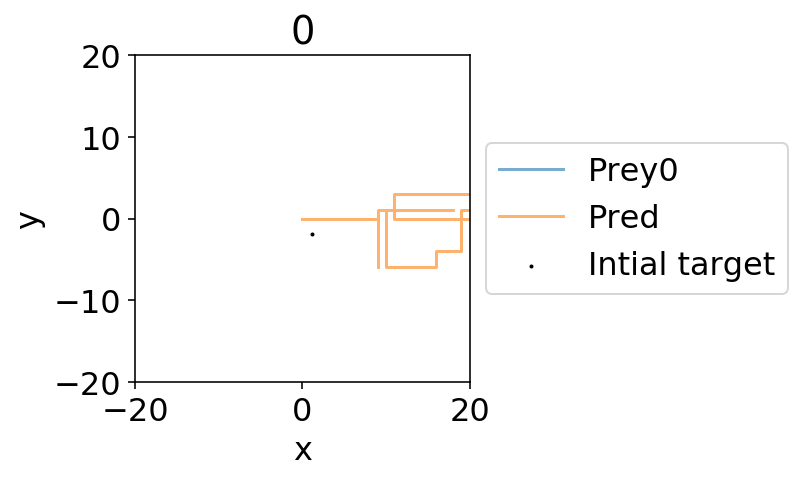

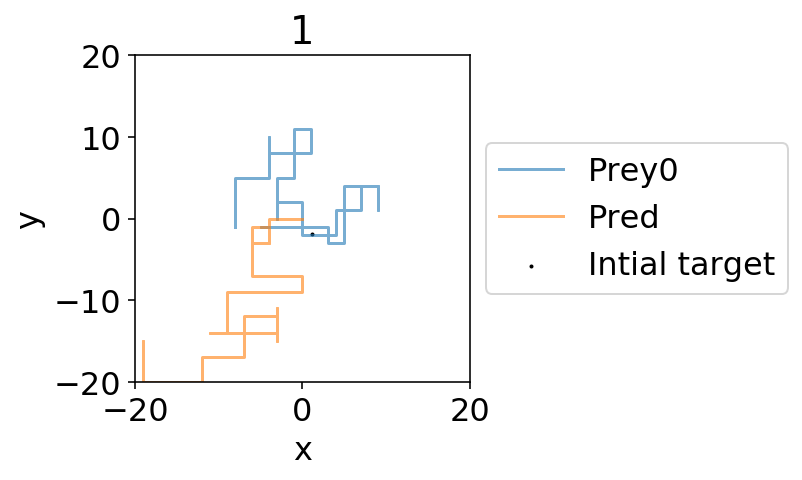

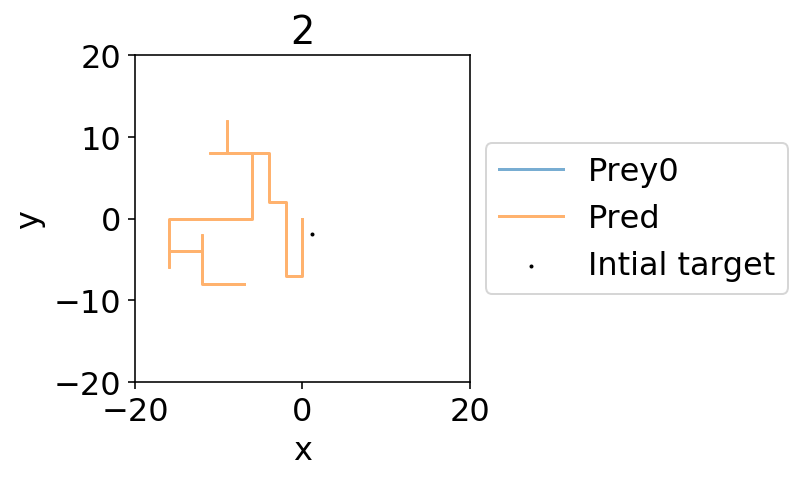

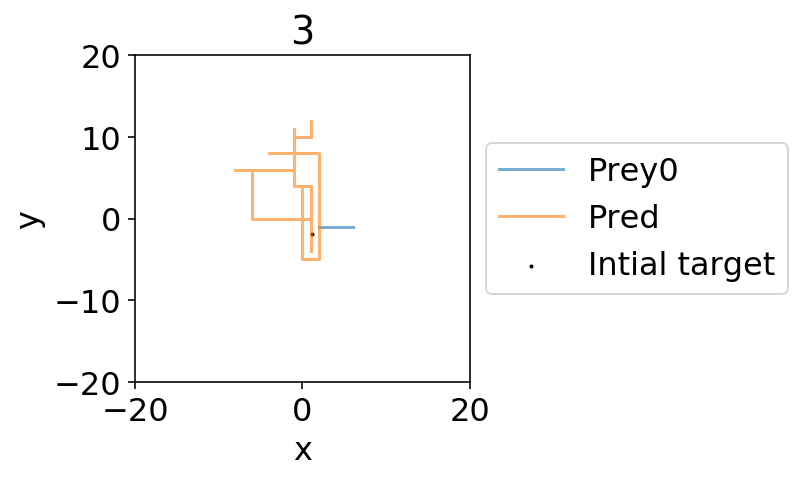

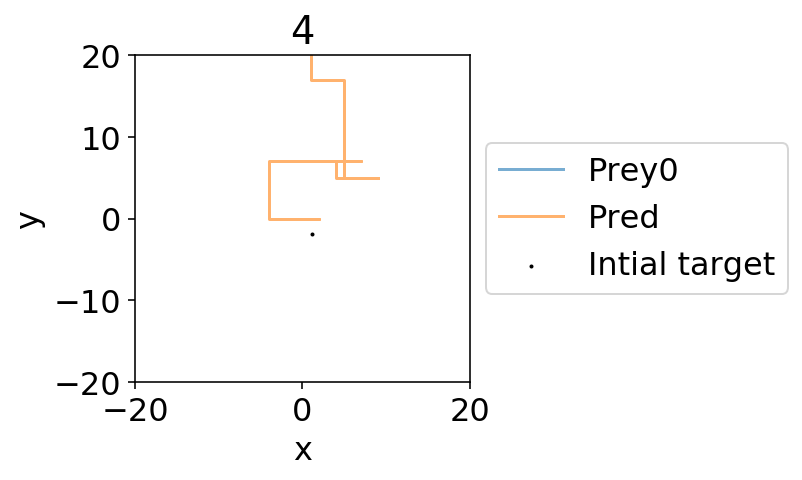

In [58]:
plot_boundary = (20, 20)
for n in range(5):
    # Example bout
    ax = None
    ax = plot_positions2d(
        select_exp(comp_exp, n),
        num_agents,
        boundary=plot_boundary,
        labels=[f"Prey{n}" for n in target_index] + ["Pred"],
        colors=None,
        alpha=0.6,
        figsize=(3, 3),
    )
    ax = plot_targets2d(
        env,
        boundary=plot_boundary,
        color="black",
        alpha=1,
        label="Intial target",
        title=n,
        ax=ax,
    )

### Analysis

In [59]:
# Est. death
pred_scores = []
prey_scores = []
for name, result in zip(model_codes, results):
    pred_scores.append(num_death(result))   
    prey_scores.append(np.sum(total_reward(result)))

# Est. fitness
fitness = np.asarray(prey_scores) - np.asarray(pred_scores)
fitness = fitness.tolist()

total_reward: 100%|██████████| 500/500 [00:00<00:00, 41061.85it/s]


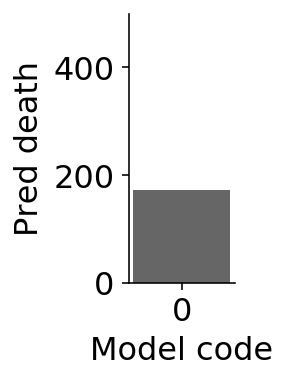

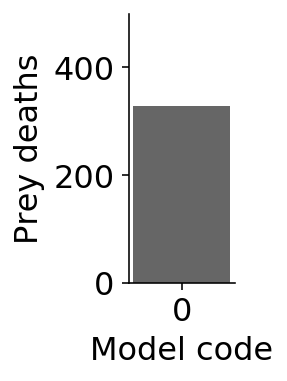

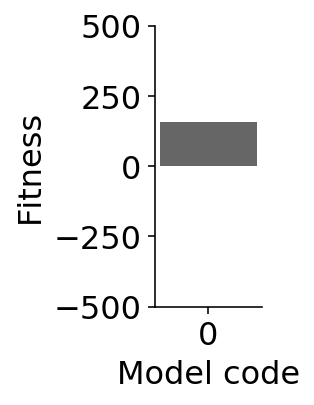

In [60]:
fig = plt.figure(figsize=(2, 3))
plt.bar([str(n) for n in model_codes], pred_scores, color="black", alpha=0.6)
plt.ylabel("Pred death")
plt.xlabel("Model code")
plt.ylim(0, num_experiments)
plt.tight_layout()
sns.despine()

fig = plt.figure(figsize=(2, 3))
plt.bar([str(n) for n in model_codes], prey_scores, color="black", alpha=0.6)
plt.ylabel("Prey deaths")
plt.xlabel("Model code")
plt.ylim(0, num_experiments)
plt.tight_layout()
sns.despine()

fig = plt.figure(figsize=(2, 3))
plt.bar([str(n) for n in model_codes], fitness, color="black", alpha=0.6)
plt.ylabel("Fitness")
plt.xlabel("Model code")
plt.tight_layout()
plt.ylim(-num_experiments, num_experiments)
sns.despine()

#### Question 1.2

Was you answer to Q 1.1 correct? Were you close? If you were wrong, or way off, please try an explain why. In what way did your intuition betray you? 

In [61]:
# Write your answer here as comment. Explain yourself

### Eagle eyes
Here we will increase the detection radius up to five fold.

#### Question 1.3

Make a guess. Will linear increases in vision (aka detection radius) give our predator a linear improvement in fitness value, for this particular task and prey starting location?

In [62]:
# Write your answer here as comment. Explain yourself.

In [63]:
detection_radii = [1, 2, 3, 4, 5]
model_codes = list(range(len(detection_radii)))

# !
results = []
for name, x in zip(model_codes, detection_radii):
    # Intial targets
    env.add_targets(
        target_index, 
        targets, 
        values, 
        detection_radius=x, 
        p_target=p_target
    )

    # Preds
    pred = [
        DiffusionGrid(
            scale=scale, 
            min_length=min_length, 
            step_size=step_size
        )
    ]

    # Preys
    preys = [
        DiffusionGrid(
            scale=scale, 
            min_length=min_length, 
            step_size=step_size
        )
    ] 

    # All agents
    agents = preys + pred

    # !
    comp_exp = multi_experiment(
        f"vision_{name}",
        agents, 
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        seed=seed_value,
        split_state=False,
        dump=False
    )
    results.append(comp_exp)

vision_4: 100%|██████████| 500/500 [00:12<00:00, 41.10it/s]


In [64]:
# Est. death
pred_scores = []
prey_scores = []
for i, result in zip(model_codes, results):
    pred_scores.append(num_death(result))   
    prey_scores.append(np.sum(total_reward(result)))

# Est. fitness
fitness = np.asarray(prey_scores) - np.asarray(pred_scores)
fitness = fitness.tolist()

total_reward: 100%|██████████| 500/500 [00:00<00:00, 28420.54it/s]


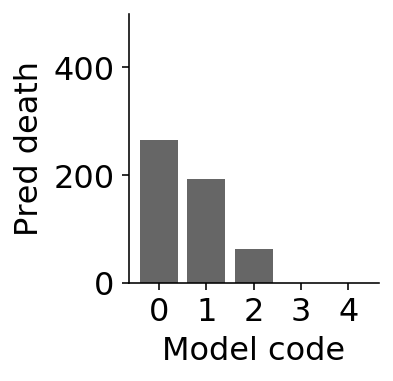

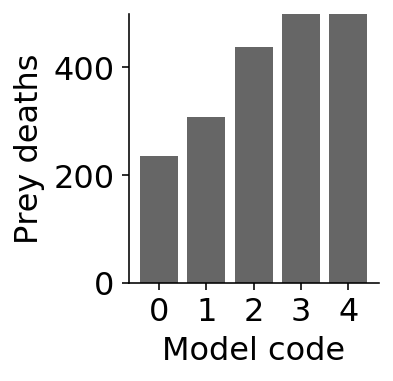

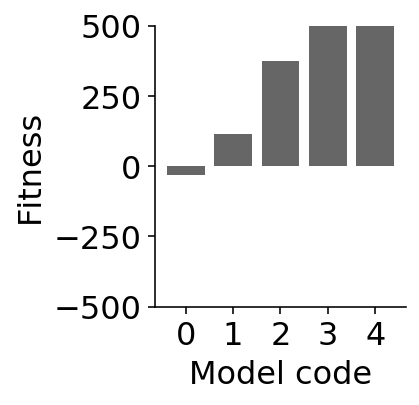

In [65]:
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], pred_scores, color="black", alpha=0.6)
plt.ylabel("Pred death")
plt.xlabel("Model code")
plt.ylim(0, num_experiments)
plt.tight_layout()
sns.despine()

fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], prey_scores, color="black", alpha=0.6)
plt.ylabel("Prey deaths")
plt.xlabel("Model code")
plt.ylim(0, num_experiments)
plt.tight_layout()
sns.despine()

fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], fitness, color="black", alpha=0.6)
plt.ylabel("Fitness")
plt.xlabel("Model code")
plt.tight_layout()
plt.ylim(-num_experiments, num_experiments)
sns.despine()

#### Question 1.5
Was your answer to the last question correct? If it was not, hypothesize why that was.

In [ ]:
# Write your answer here as comment. Explain yourself.

### The fast and the....
Here we will increase the step size of the predator up to five fold. This is akin to increasing its speed relative to the target.

#### Question 1.6

Make a guess. Will linear increases in speed (aka step size) give our predator a linear improvement in fitness value, for this particular task and prey starting location?

In [67]:
# Write your answer here as comment. Explain yourself.

In [68]:
target_step_sizes = [1, 2, 3, 4, 5]
model_codes = list(range(len(target_step_sizes)))

# !
results = []
for name, x in zip(model_codes, target_step_sizes):
    # Intial targets
    env.add_targets(
        target_index, 
        targets, 
        values, 
        detection_radius=detection_radius, 
        p_target=p_target
    )

    # Preds
    pred = [
        DiffusionGrid(
            scale=scale, 
            min_length=min_length, 
            step_size=x
        )
    ]

    # Preys
    preys = [
        DiffusionGrid(
            scale=scale, 
            min_length=min_length, 
            step_size=step_size
        )
    ] 

    # All agents
    agents = preys + pred

    # !
    comp_exp = multi_experiment(
        f"speed_{name}",
        agents, 
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        seed=seed_value,
        split_state=False,
        dump=False
    )
    results.append(comp_exp)

speed_4: 100%|██████████| 500/500 [00:15<00:00, 31.89it/s]


In [69]:
# ---
# Est. death
pred_scores = []
prey_scores = []
for i, result in zip(model_codes, results):
    pred_scores.append(num_death(result))   
    prey_scores.append(np.sum(total_reward(result)))

# Est. fitness
fitness = np.asarray(prey_scores) - np.asarray(pred_scores)
fitness = fitness.tolist()

total_reward: 100%|██████████| 500/500 [00:00<00:00, 33326.21it/s]


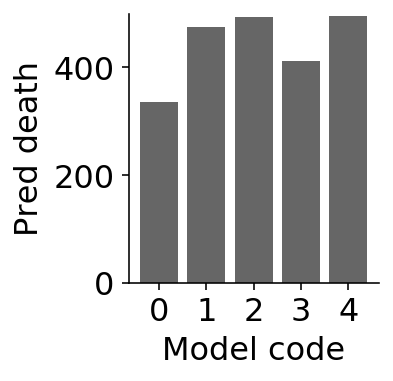

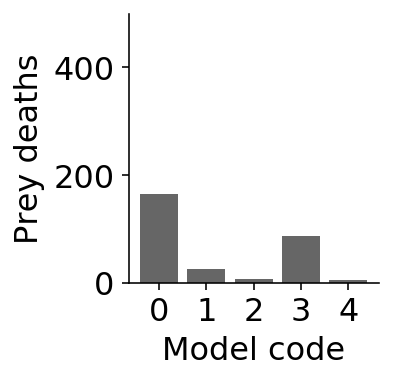

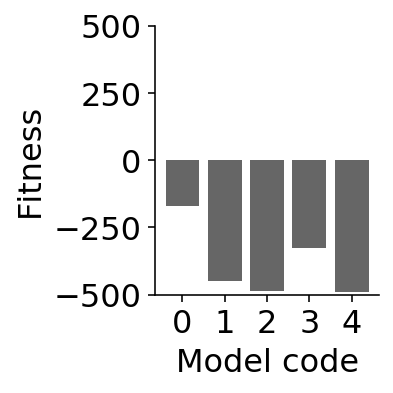

In [70]:
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], pred_scores, color="black", alpha=0.6)
plt.ylabel("Pred death")
plt.xlabel("Model code")
plt.ylim(0, num_experiments)
plt.tight_layout()
sns.despine()

fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], prey_scores, color="black", alpha=0.6)
plt.ylabel("Prey deaths")
plt.xlabel("Model code")
plt.ylim(0, num_experiments)
plt.tight_layout()
sns.despine()

fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], fitness, color="black", alpha=0.6)
plt.ylabel("Fitness")
plt.xlabel("Model code")
plt.tight_layout()
plt.ylim(-num_experiments, num_experiments)
sns.despine()

#### Question 1.7
Was your answer to the last question correct? If it was not, hypothesize why that was.

In [ ]:
# Write your answer here as a comment. Explain yourself

### Range anxiety
Here we will increase the range/scale of the predator up to five fold. This is akin to increasing how far it will travel in a fixed time interval.

#### Question 1.8

Make a guess. Will linear increases in exploration range (aka scale) give our predator a linear improvement in fitness value, for this particular task and prey starting location?

In [ ]:
# Write your answer here as a comment. Explain yourself

In [71]:
pred_scales = [1, 2, 3, 4, 5]
model_codes = list(range(len(pred_scales)))

# !
results = []
for name, x in zip(model_codes, pred_scales):
    # Intial targets
    env.add_targets(
        target_index, 
        targets, 
        values, 
        detection_radius=detection_radius, 
        p_target=p_target
    )

    # Preds
    pred = [
        DiffusionGrid(
            scale=x, 
            min_length=min_length, 
            step_size=step_size
        )
    ]

    # Preys
    preys = [
        DiffusionGrid(
            scale=scale, 
            min_length=min_length, 
            step_size=step_size
        )
    ] 

    # All agents
    agents = preys + pred

    # !
    comp_exp = multi_experiment(
        f"scale_{name}",
        agents, 
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        seed=seed_value,
        split_state=False,
        dump=False
    )
    results.append(comp_exp)

scale_4: 100%|██████████| 500/500 [00:16<00:00, 30.43it/s]


In [72]:
# ---
# Est. death
pred_scores = []
prey_scores = []
for i, result in zip(model_codes, results):
    pred_scores.append(num_death(result))   
    prey_scores.append(np.sum(total_reward(result)))

# Est. fitness
fitness = np.asarray(prey_scores) - np.asarray(pred_scores)
fitness = fitness.tolist()

total_reward: 100%|██████████| 500/500 [00:00<00:00, 29256.73it/s]


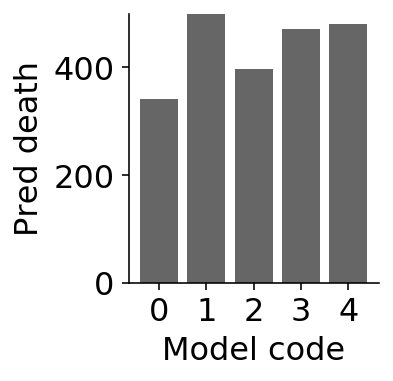

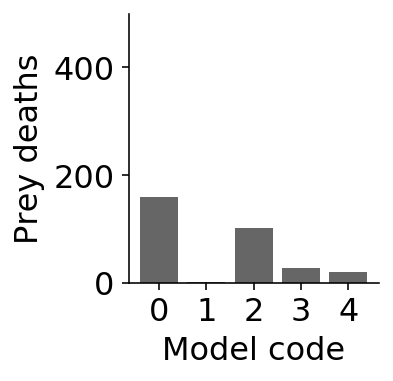

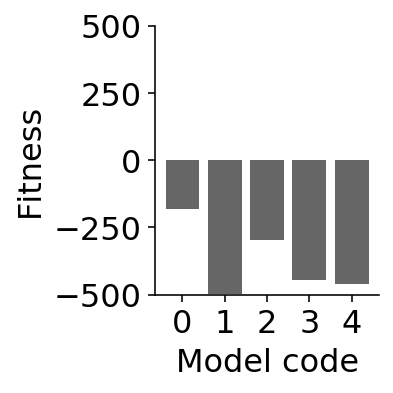

In [73]:
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], pred_scores, color="black", alpha=0.6)
plt.ylabel("Pred death")
plt.xlabel("Model code")
plt.ylim(0, num_experiments)
plt.tight_layout()
sns.despine()

fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], prey_scores, color="black", alpha=0.6)
plt.ylabel("Prey deaths")
plt.xlabel("Model code")
plt.ylim(0, num_experiments)
plt.tight_layout()
sns.despine()

fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], fitness, color="black", alpha=0.6)
plt.ylabel("Fitness")
plt.xlabel("Model code")
plt.tight_layout()
plt.ylim(-num_experiments, num_experiments)
sns.despine()

#### Question 1.9
Was your answer to the last question correct? If it was not, hypothesize why that was.

In [ ]:
# Write your answer here as comment. Explain yourself.

### Hunting buddies
Will aadding more predators help? If, that is, everything else is the same as our base case.

#### Question 1.10

Make a guess. Will linear increases in predators give a linear improvement in fitness value, for this particular task and prey starting location?

In [74]:
# Write your answer here as comment. Explain yourself.

In [76]:
num_predators = [1, 2, 3, 4, 5]
model_codes = list(range(len(num_predators)))

# !
results = []
for name, x in zip(model_codes, num_predators):
    x_num_agents = 1 + x
    x_num_targets = 1
    x_target_index = list(range(0, x_num_targets))

    # Create env 
    x_env = CompetitiveGrid(num_agents=x_num_agents, mode=None)
    x_targets = uniform_targets(x_num_targets, target_boundary, prng=prng)
    x_values = constant_values(x_targets, 1.0)

    # Intial targets
    x_env.add_targets(
        x_target_index, 
        x_targets, 
        x_values, 
        detection_radius=detection_radius, 
        p_target=p_target
    )

    # Preds
    preds = [
        DiffusionGrid(
            scale=scale, 
            min_length=min_length, 
            step_size=step_size
        )
    ] * x

    # Preys
    preys = [
        DiffusionGrid(
            scale=scale, 
            min_length=min_length, 
            step_size=step_size
        )
    ] 

    # All agents
    agents = preys + pred

    # !
    comp_exp = multi_experiment(
        f"pred_{name}",
        agents, 
        x_env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        seed=seed_value,
        split_state=False,
        dump=False
    )
    results.append(comp_exp)

pred_4: 100%|██████████| 500/500 [00:17<00:00, 28.75it/s]


In [79]:
# Est. death
pred_scores = []
prey_scores = []
for i, result in zip(model_codes, results):
    pred_scores.append(num_death(result))   
    prey_scores.append(np.sum(total_reward(result)))

# Est. fitness
fitness = np.asarray(prey_scores) - np.asarray(pred_scores)
fitness = fitness.tolist()

total_reward: 100%|██████████| 500/500 [00:00<00:00, 31520.48it/s]


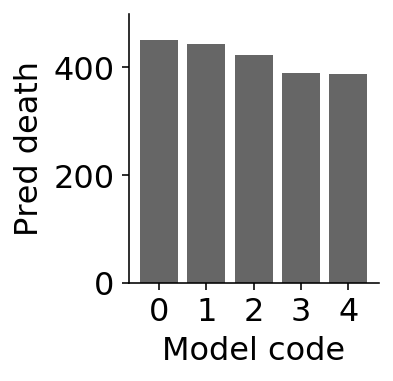

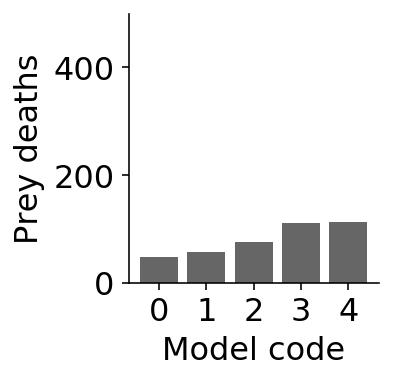

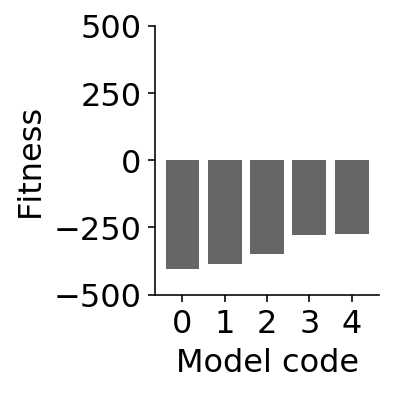

In [80]:
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], pred_scores, color="black", alpha=0.6)
plt.ylabel("Pred death")
plt.xlabel("Model code")
plt.ylim(0, num_experiments)
plt.tight_layout()
sns.despine()

fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], prey_scores, color="black", alpha=0.6)
plt.ylabel("Prey deaths")
plt.xlabel("Model code")
plt.ylim(0, num_experiments)
plt.tight_layout()
sns.despine()

fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], fitness, color="black", alpha=0.6)
plt.ylabel("Fitness")
plt.xlabel("Model code")
plt.tight_layout()
plt.ylim(-num_experiments, num_experiments)
sns.despine()

#### Question 1.11
Was your answer to the last question correct? If it was not, hypothesize why that was.

In [ ]:
# Write your answer here as comment. Explain yourself.

### No one can see me!?

Here we will increase the prey's ability to escape, _p escape_.

#### Question 1.12

Make a guess. Will linear increases to p escape give a linear decrease in fitness value, for this particular task and prey starting location?

In [81]:
# Write your answer here as comment. Explain yourself.

In [83]:
p_escapes = [0.1, 0.2, 0.3, 0.4, 0.5]
model_codes = list(range(len(p_escapes)))

# !
results = []
for name, x in zip(model_codes, p_escapes):
    # Intial targets
    env.add_targets(
        target_index, 
        targets, 
        values, 
        detection_radius=detection_radius, 
        p_target=1 - x,
    )

    # Preds
    pred = [
        DiffusionGrid(
            scale=scale, 
            min_length=min_length, 
            step_size=step_size
        )
    ]

    # Preys
    preys = [
        DiffusionGrid(
            scale=scale, 
            min_length=min_length, 
            step_size=step_size
        )
    ] 

    # All agents
    agents = preys + pred

    # !
    comp_exp = multi_experiment(
        f"escape_{name}",
        agents, 
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        seed=seed_value,
        split_state=False,
        dump=False
    )
    results.append(comp_exp)

escape_4: 100%|██████████| 500/500 [00:17<00:00, 28.43it/s]


In [84]:
# Est. death
pred_scores = []
prey_scores = []
for i, result in zip(model_codes, results):
    pred_scores.append(num_death(result))   
    prey_scores.append(np.sum(total_reward(result)))

# Est. fitness
fitness = np.asarray(prey_scores) - np.asarray(pred_scores)
fitness = fitness.tolist()

total_reward: 100%|██████████| 500/500 [00:00<00:00, 19735.49it/s]


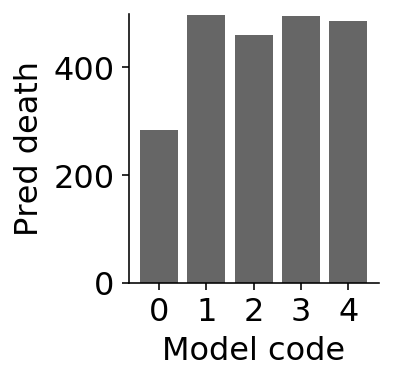

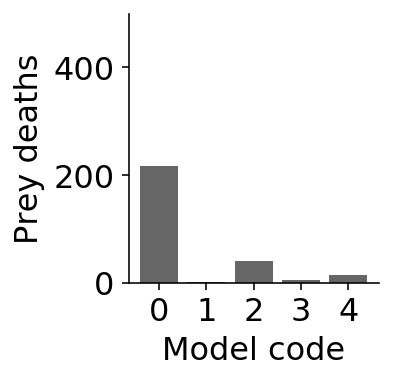

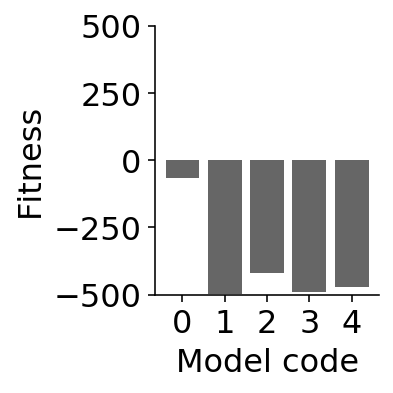

In [85]:
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], pred_scores, color="black", alpha=0.6)
plt.ylabel("Pred death")
plt.xlabel("Model code")
plt.ylim(0, num_experiments)
plt.tight_layout()
sns.despine()

fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], prey_scores, color="black", alpha=0.6)
plt.ylabel("Prey deaths")
plt.xlabel("Model code")
plt.ylim(0, num_experiments)
plt.tight_layout()
sns.despine()

fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], fitness, color="black", alpha=0.6)
plt.ylabel("Fitness")
plt.xlabel("Model code")
plt.tight_layout()
plt.ylim(-num_experiments, num_experiments)
sns.despine()

In [106]:
#### Question 1.13
Was your answer to the last question correct? If it was not, hypothesize why that was.

SyntaxError: invalid syntax (<ipython-input-106-b953e348d846>, line 2)

In [ ]:
# Write your answer here as comment. Explain yourself.

## Section 2 - Life is in your hands now....

In this section you will be given 10 "evolution points". They can spent on step size, scale, num_predators. The domain is now bigger, and the are 12 prey of three different "species".

In [102]:
# Spend here
scale = 2
detection_radius = 1
step_size = 1
num_predators = 1

In [112]:
preys = [
    # Fast
    DiffusionGrid(scale=scale*2, min_length=min_length, step_size=step_size*2),
    DiffusionGrid(scale=scale*2, min_length=min_length, step_size=step_size*2),
    DiffusionGrid(scale=scale*2, min_length=min_length, step_size=step_size*2),
    DiffusionGrid(scale=scale*2, min_length=min_length, step_size=step_size*2),
    # Flight
    LevyGrid(exponent=2, step_size=step_size),
    LevyGrid(exponent=2, step_size=step_size),
    LevyGrid(exponent=2, step_size=step_size),
    LevyGrid(exponent=2, step_size=step_size),
    # Freeze
    FreezeLevyGrid(p_freeze=0.9, exponent=2,step_size=step_size),
    FreezeLevyGrid(p_freeze=0.9, exponent=2,step_size=step_size),
    FreezeLevyGrid(p_freeze=0.9, exponent=2,step_size=step_size),
    FreezeLevyGrid(p_freeze=0.9, exponent=2,step_size=step_size)
] 

# Shared env params
num_steps = 100
num_experiments = 500
seed_value = 559

num_targets = len(preys)
target_index = list(range(0, num_targets))
num_agents = num_predators + num_targets

p_target = 0.5

target_boundary = (10, 10)
min_length = 1

# Create env 
prng = np.random.RandomState(seed_value)
env = CompetitiveGrid(num_agents=num_agents, mode=None)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1.0)

# Run
model_codes = [0]
results = []

# Intial targets
env.add_targets(
    target_index, 
    targets, 
    values, 
    detection_radius=detection_radius, 
    p_target=p_target,
)

# Preds
preds = [
    DiffusionGrid(
        scale=scale, 
        min_length=min_length, 
        step_size=step_size
    )
] * num_predators

# All agents
agents = preys + preds

# !
comp_exp = multi_experiment(
    f"oracle",
    agents, 
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    seed=seed_value,
    split_state=False,
    dump=False
)

results.append(comp_exp)

oracle: 100%|██████████| 500/500 [01:35<00:00,  5.23it/s]


In [109]:
# Est. death
pred_scores = []
prey_scores = []
for i, result in zip(model_codes, results):
    pred_scores.append(num_death(result))   
    prey_scores.append(np.sum(total_reward(result)))

# Est. fitness
fitness = np.asarray(prey_scores) - np.asarray(pred_scores)
fitness = fitness.tolist()

total_reward: 100%|██████████| 500/500 [00:00<00:00, 8934.47it/s]


The fitness was [-500.0]


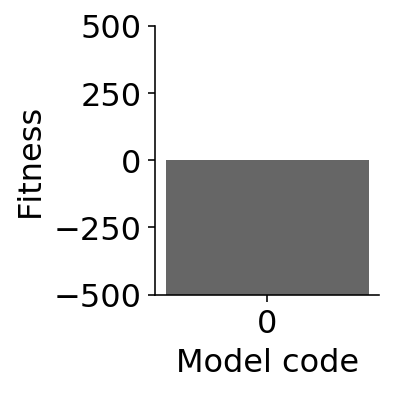

In [111]:
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in model_codes], fitness, color="black", alpha=0.6)
plt.ylabel("Fitness")
plt.xlabel("Model code")
plt.tight_layout()
plt.ylim(-num_experiments, num_experiments)
sns.despine()
print(f"The fitness was {fitness}")